In [55]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, collect_list, month, sum
from calendar import month_name
from pyspark.sql.types import IntegerType
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pandas as pd

In [2]:
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

In [3]:
# create a SparkSession
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/17 18:18:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
temperatures_path = 'global_temps_by_country.csv'

In [5]:
temperatures_df = spark.read.csv(temperatures_path, header = True, inferSchema = True)

In [6]:
# will use year pyspark sql function to group monthly average temperatures by year
# to show the collected monthly values, use the aggregate function collect_list()
grouped_temp = temperatures_df.groupBy(year(temperatures_df['dt']).alias('year'), col("Country").alias('country'))\
                            .agg(collect_list("AverageTemperature").alias('monthly_avg_temp'))

In [7]:
# get data from 1750 and onward, to remove blank values
grouped_temp = grouped_temp.filter(grouped_temp.year >= 1750)

In [8]:
grouped_temp.show()

+----+--------------------+--------------------+
|year|             country|    monthly_avg_temp|
+----+--------------------+--------------------+
|1750|             Belgium|[1.17099999999999...|
|1750|            Bulgaria|[0.34, 2.016, 6.0...|
|1750|       Faroe Islands|[5.194, 6.182, 5....|
|1750|             Finland|[-7.7589999999999...|
|1750|              Greece|[6.239, 7.5489999...|
|1750|             Hungary|[-1.1420000000000...|
|1750|               Italy|[4.339, 6.8329999...|
|1750|              Latvia|[-2.909, -2.325, ...|
|1750|       Liechtenstein|[-4.742, -0.98000...|
|1750|           Macedonia|[-0.2, 2.271, 6.6...|
|1750|              Monaco|[-0.1829999999999...|
|1750|              Norway|[-6.2930000000000...|
|1750|            Slovenia|[-0.358, 3.028, 6...|
|1750|             Ukraine|[-3.628, -2.71900...|
|1750|      United Kingdom|[3.928, 6.654, 7....|
|1751|Bosnia And Herzeg...|[-0.2179999999999...|
|1751|      Czech Republic|[-3.0860000000000...|
|1751|              

In [9]:
# get list of month names and account for empty first entry
month_names = list(month_name)[1:]

# create a new column for each month
# can use getItem() on list of month names
for i, month in enumerate(month_names):
    grouped_temp = grouped_temp.withColumn(month, col('monthly_avg_temp').getItem(i))

# drop the old column consisting of lists
grouped_temp = grouped_temp.drop('monthly_avg_temp')

In [10]:
grouped_temp.toPandas()

,year,country,January,February,March,April,May,June,July,August,September,October,November,December
0,1750,Belgium,1.171,5.490,8.131,8.928,13.186,15.904,19.100,17.114,14.794,7.873,2.064,NaN
1,1750,Bulgaria,0.340,2.016,6.040,9.921,14.926,18.744,22.664,21.153,16.076,8.842,0.498,NaN
2,1750,Faroe Islands,5.194,6.182,5.966,5.763,6.905,8.664,11.709,11.471,9.602,4.520,2.835,NaN
3,1750,Finland,-7.759,-7.620,-4.900,1.007,6.080,12.665,16.621,15.126,7.451,-2.322,-11.859,NaN
4,1750,Greece,6.239,7.549,10.415,12.993,17.728,21.714,26.096,24.614,19.939,13.383,6.395,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47888,2013,United Kingdom (Europe),3.959,3.384,2.990,6.635,9.826,13.285,17.011,15.776,NaN,NaN,NaN,NaN
47889,2013,United States,-2.155,-1.216,2.289,6.970,14.073,20.198,22.074,21.168,18.273,NaN,NaN,NaN
47890,2013,Virgin Islands,25.594,25.594,25.860,26.481,27.493,28.021,28.630,29.147,28.991,NaN,NaN,NaN
47891,2013,Zambia,23.072,23.636,23.249,21.710,20.045,18.703,18.266,20.887,NaN,NaN,NaN,NaN


In [11]:
temp_US = grouped_temp.filter(grouped_temp.country == 'United States')
#.filter(grouped_temp.year >= 1850)

In [12]:
temp_US.toPandas()

,year,country,January,February,March,April,May,June,July,August,September,October,November,December
0,1768,United States,15.420,8.162,1.591,-2.882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1769,United States,-3.952,-2.684,1.828,8.843,15.724,20.933,22.093,20.787,NaN,NaN,NaN,NaN
2,1770,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1771,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1772,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2009,United States,-3.569,-0.310,2.833,8.172,14.884,18.962,21.463,20.436,17.167,8.534,4.251,-3.178
242,2010,United States,-3.610,-2.105,3.436,9.550,14.174,19.885,22.078,21.703,17.384,10.913,3.601,-2.942
243,2011,United States,-3.507,-1.881,3.462,8.582,13.759,19.578,22.722,21.915,17.148,10.490,2.966,-0.635
244,2012,United States,-2.268,0.582,6.024,10.196,15.422,19.954,23.008,21.422,17.036,9.688,3.330,-1.261


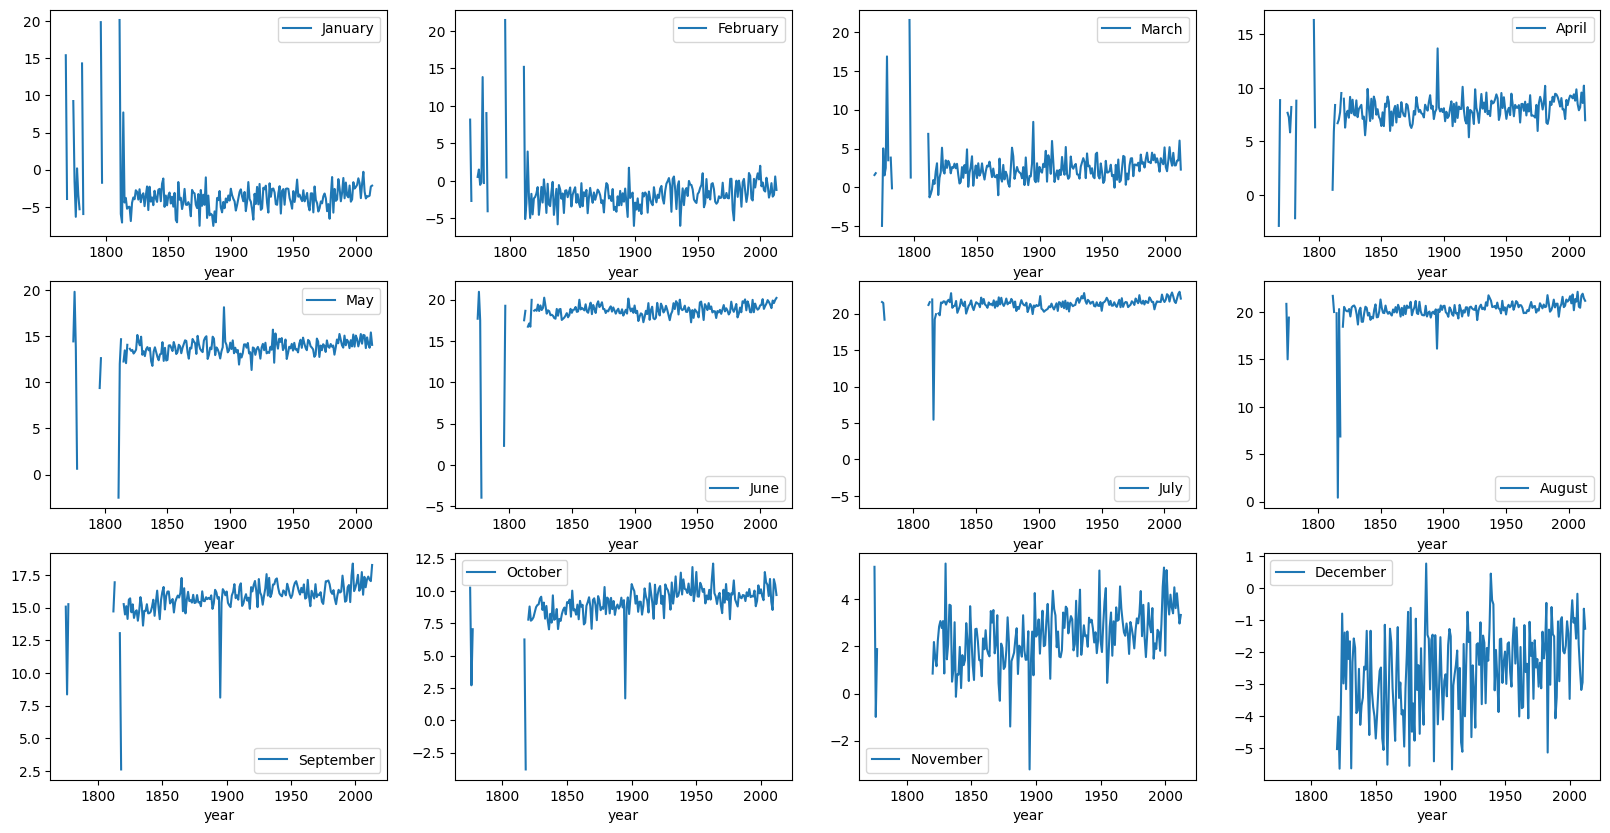

In [13]:
nrows=3
ncols=4
plt.rcParams['figure.figsize'] = [20, 10]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

for _,month in enumerate(month_names):
    axes_loc = [axes[i,j] for i in range(nrows) for j in range(ncols)]
    temp_US.toPandas().plot(x='year', y=month, ax=axes_loc[_])

In [14]:
# find rows containing null values
temp_US.toPandas()[temp_US.toPandas().isnull().any(axis=1)]

,year,country,January,February,March,April,May,June,July,August,September,October,November,December
0,1768,United States,15.420,8.162,1.591,-2.882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1769,United States,-3.952,-2.684,1.828,8.843,15.724,20.933,22.093,20.787,NaN,NaN,NaN,NaN
2,1770,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1771,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1772,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1773,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1774,United States,9.244,0.522,-4.957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1776,United States,-6.358,-0.540,1.541,7.254,19.836,20.940,21.476,14.999,8.351,2.703,-0.992,NaN
10,1778,United States,-3.402,13.835,16.855,8.203,0.630,-3.949,NaN,NaN,NaN,NaN,NaN,NaN
11,1779,United States,-5.338,-0.293,3.490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# remove rows with null values to perform some basic analysis methods properly
temp_US = temp_US.select("*").where(temp_US.year.between(1820,2012))

In [16]:
temp_US.toPandas()

,year,country,January,February,March,April,May,June,July,August,September,October,November,December
0,1820,United States,-6.929,-2.158,1.227,8.978,13.647,18.656,20.031,18.438,15.276,7.785,0.845,-5.030
1,1821,United States,-4.464,-1.684,1.953,6.281,13.429,18.779,19.775,20.527,14.480,8.803,2.184,-4.014
2,1822,United States,-3.755,-0.841,5.106,7.528,13.527,18.640,21.539,20.211,15.117,7.702,1.512,-5.644
3,1823,United States,-3.994,-4.542,2.172,7.855,13.135,19.397,21.453,20.076,14.138,7.790,1.158,-3.706
4,1824,United States,-2.778,-2.892,1.779,7.206,13.308,18.610,21.696,20.063,15.616,7.966,2.241,-0.788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2008,United States,-3.883,-1.586,2.828,7.902,13.723,19.381,21.690,20.543,16.567,9.164,3.620,-2.532
189,2009,United States,-3.569,-0.310,2.833,8.172,14.884,18.962,21.463,20.436,17.167,8.534,4.251,-3.178
190,2010,United States,-3.610,-2.105,3.436,9.550,14.174,19.885,22.078,21.703,17.384,10.913,3.601,-2.942
191,2011,United States,-3.507,-1.881,3.462,8.582,13.759,19.578,22.722,21.915,17.148,10.490,2.966,-0.635


In [17]:
# calculate Pearson correlation coefficient
for month in month_names:
    corr_value = temp_US.toPandas()['year'].corr(temp_US.toPandas()[month],method='pearson', min_periods=1)
    print('Pearson correlation coefficient between year and {}: {}'.format(month, corr_value))

Pearson correlation coefficient between year and January: 0.22546198869817022
Pearson correlation coefficient between year and February: 0.30605442713825753
Pearson correlation coefficient between year and March: 0.28757045370910955
Pearson correlation coefficient between year and April: 0.300192663261528
Pearson correlation coefficient between year and May: 0.330846321916339
Pearson correlation coefficient between year and June: 0.2623988552046169
Pearson correlation coefficient between year and July: 0.35214474893319664
Pearson correlation coefficient between year and August: 0.4669631227750905
Pearson correlation coefficient between year and September: 0.5786110305772397
Pearson correlation coefficient between year and October: 0.4793363914164332
Pearson correlation coefficient between year and November: 0.40215626386719977
Pearson correlation coefficient between year and December: 0.3393388376952702


In [18]:
# calculate Spearman correlation coefficient
for month in month_names:
    corr_value = temp_US.toPandas()['year'].corr(temp_US.toPandas()[month],method='spearman', min_periods=1)
    print('Pearson correlation coefficient between year and {}: {}'.format(month, corr_value))

Pearson correlation coefficient between year and January: 0.2122094042278413
Pearson correlation coefficient between year and February: 0.29110632036419815
Pearson correlation coefficient between year and March: 0.30832559566185946
Pearson correlation coefficient between year and April: 0.31772431075627344
Pearson correlation coefficient between year and May: 0.353495860457253
Pearson correlation coefficient between year and June: 0.26243884280864715
Pearson correlation coefficient between year and July: 0.33066697603821404
Pearson correlation coefficient between year and August: 0.48469205500289214
Pearson correlation coefficient between year and September: 0.6101113223649771
Pearson correlation coefficient between year and October: 0.5880638521986389
Pearson correlation coefficient between year and November: 0.4174458234761058
Pearson correlation coefficient between year and December: 0.3330565158391542


0.05083310834773391
0.09366931237092702
0.08269676584646313
0.09011563507604903
0.10945928872556987
0.06885315921269342
0.12400592420122414
0.21805455803186435
0.3347907247056554
0.22976337613612807
0.16172966056762483
0.11515084676837684


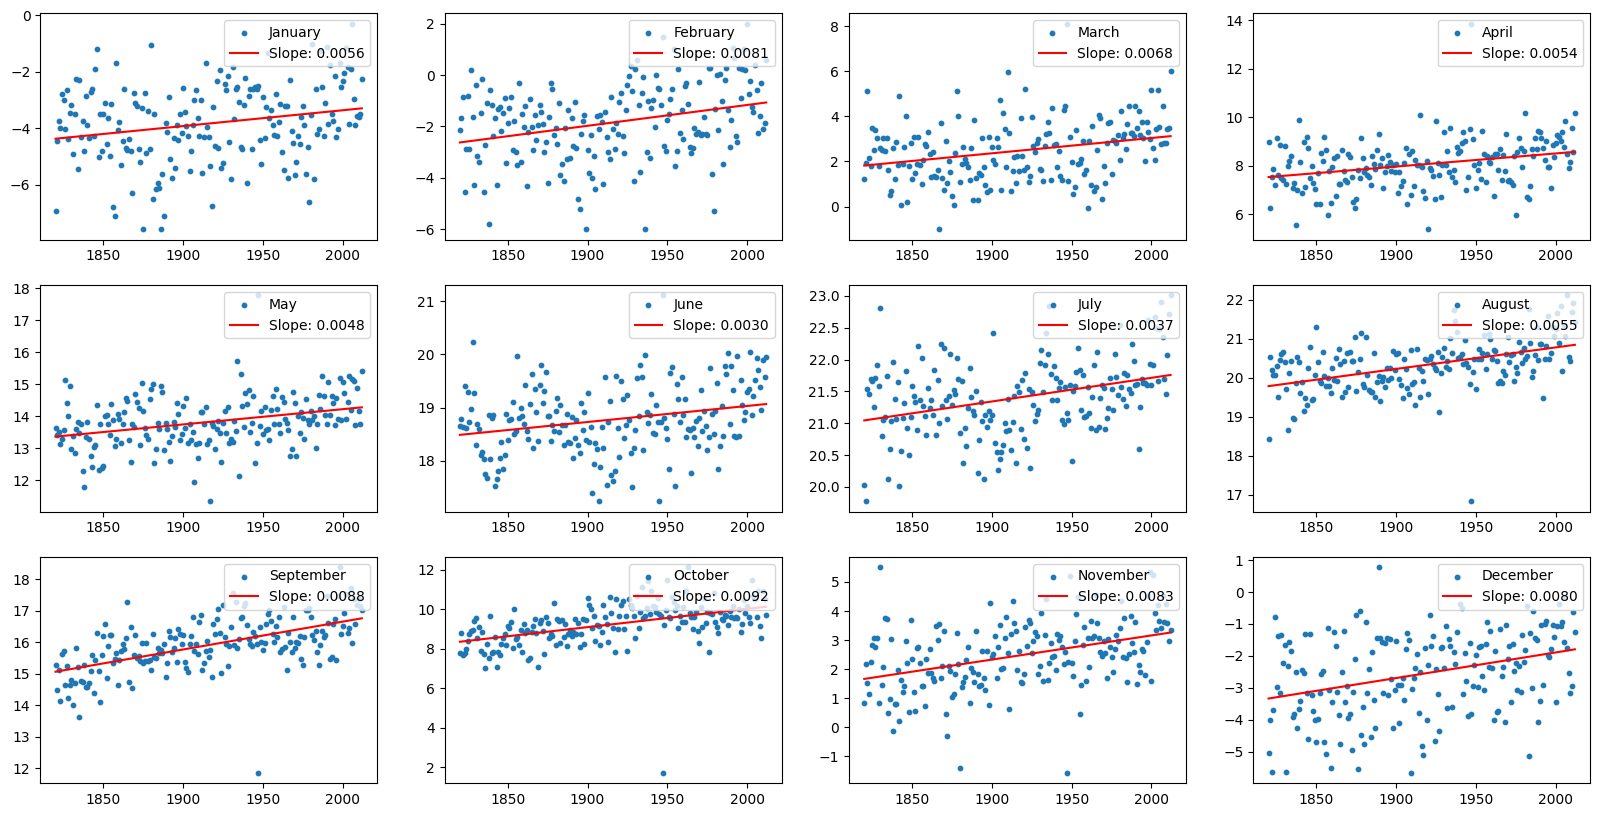

In [19]:
nrows=3
ncols=4
plt.rcParams['figure.figsize'] = [20, 10]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
linear_regressor = LinearRegression()

for index,month in enumerate(month_names):
    # .values returns a numpy array
    # .reshape(number_of_rows, number_of_cols)
    # use -1 for one of the values to mean unknown, for numpy to figure out
    X = temp_US.toPandas().loc[:,'year'].values.reshape(-1,1)
    Y = temp_US.toPandas().loc[:, month].values.reshape(-1,1)
    # perform linear regression
    linear_regressor = LinearRegression().fit(X, Y)
    score = linear_regressor.score(X,Y)
    print(score)
    
    # make predictions
    Y_pred = linear_regressor.predict(X)  
    
    axes_loc = [axes[i, j] for i in range(nrows) for j in range(ncols)]
    ax = axes_loc[index]
    
    # specify marker size with s parameter, default is 20
    # pandas.DataFrame.plot() automatically includes legend but need to specify here
    ax.scatter(X, Y, s=10, label=f"{month}")
    # get slope from regression model
    slope = linear_regressor.coef_[0] 
    ax.plot(X, Y_pred, color='red', label=f'Slope: {float(slope):.4f}')
    ax.legend(loc="upper right")
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    #linear_regressor.fit(X_train, Y_train)
    # prints coefficient of determination of the prediction
    
plt.show()

In [20]:
co2_path = 'annual_co2_emissions.csv'
co2_df = spark.read.csv(co2_path, header = True, inferSchema = True)

In [21]:
co2_df.show()

+-----------+----+----+--------------------+
|     Entity|Code|Year|Annual CO₂ emissions|
+-----------+----+----+--------------------+
|Afghanistan| AFG|1949|             14656.0|
|Afghanistan| AFG|1950|             84272.0|
|Afghanistan| AFG|1951|             91600.0|
|Afghanistan| AFG|1952|             91600.0|
|Afghanistan| AFG|1953|            106256.0|
|Afghanistan| AFG|1954|            106256.0|
|Afghanistan| AFG|1955|            153888.0|
|Afghanistan| AFG|1956|            183200.0|
|Afghanistan| AFG|1957|            293120.0|
|Afghanistan| AFG|1958|            329760.0|
|Afghanistan| AFG|1959|            384571.0|
|Afghanistan| AFG|1960|            413885.0|
|Afghanistan| AFG|1961|            490798.0|
|Afghanistan| AFG|1962|            688594.0|
|Afghanistan| AFG|1963|            706736.0|
|Afghanistan| AFG|1964|            838551.0|
|Afghanistan| AFG|1965|           1006917.0|
|Afghanistan| AFG|1966|           1091159.0|
|Afghanistan| AFG|1967|           1281865.0|
|Afghanist

In [22]:
grouped_temp.toPandas()

,year,country,January,February,March,April,May,June,July,August,September,October,November,December
0,1750,Belgium,1.171,5.490,8.131,8.928,13.186,15.904,19.100,17.114,14.794,7.873,2.064,NaN
1,1750,Bulgaria,0.340,2.016,6.040,9.921,14.926,18.744,22.664,21.153,16.076,8.842,0.498,NaN
2,1750,Faroe Islands,5.194,6.182,5.966,5.763,6.905,8.664,11.709,11.471,9.602,4.520,2.835,NaN
3,1750,Finland,-7.759,-7.620,-4.900,1.007,6.080,12.665,16.621,15.126,7.451,-2.322,-11.859,NaN
4,1750,Greece,6.239,7.549,10.415,12.993,17.728,21.714,26.096,24.614,19.939,13.383,6.395,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47888,2013,United Kingdom (Europe),3.959,3.384,2.990,6.635,9.826,13.285,17.011,15.776,NaN,NaN,NaN,NaN
47889,2013,United States,-2.155,-1.216,2.289,6.970,14.073,20.198,22.074,21.168,18.273,NaN,NaN,NaN
47890,2013,Virgin Islands,25.594,25.594,25.860,26.481,27.493,28.021,28.630,29.147,28.991,NaN,NaN,NaN
47891,2013,Zambia,23.072,23.636,23.249,21.710,20.045,18.703,18.266,20.887,NaN,NaN,NaN,NaN


In [23]:
temp_co2 = grouped_temp.join(co2_df, (grouped_temp['year']==co2_df['Year'])\
                    & (grouped_temp['country']==co2_df['Entity']))\
                .drop(co2_df['Entity']).drop(co2_df['Year']).drop(co2_df['Code'])

In [24]:
temp_co2.toPandas()

,year,country,January,February,March,April,May,June,July,August,September,October,November,December,Annual CO₂ emissions
0,1750,United Kingdom,3.928,6.654,7.611,7.471,10.242,12.493,15.674,14.231,12.257,6.613,3.412,NaN,9.350528e+06
1,1753,United Kingdom,1.987,3.916,7.009,7.111,10.227,13.838,14.392,13.309,12.073,9.376,5.015,2.860,9.354192e+06
2,1754,Andorra,2.327,1.831,4.399,10.014,14.141,18.166,19.618,20.325,16.315,13.065,8.684,4.509,0.000000e+00
3,1754,Iceland,-3.912,-5.829,-3.614,2.191,4.276,7.692,8.487,7.451,4.058,1.896,-1.395,-2.606,0.000000e+00
4,1756,Europe,-0.084,1.969,2.713,6.976,12.180,17.826,18.605,16.394,14.163,7.501,1.078,-2.586,1.000638e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20476,2013,Tonga,25.958,26.140,26.152,25.287,24.141,22.899,21.829,21.881,NaN,NaN,NaN,NaN,1.135840e+05
20477,2013,Turkmenistan,4.455,6.316,11.505,15.954,23.377,28.502,30.647,28.152,NaN,NaN,NaN,NaN,7.060876e+07
20478,2013,United Kingdom,4.354,3.773,3.351,6.789,9.605,12.826,16.260,15.022,NaN,NaN,NaN,NaN,4.776113e+08
20479,2013,United States,-2.155,-1.216,2.289,6.970,14.073,20.198,22.074,21.168,18.273,NaN,NaN,NaN,5.480926e+09


In [25]:
temp_co2.toPandas()[temp_co2.toPandas().isnull().any(axis=1)]

,year,country,January,February,March,April,May,June,July,August,September,October,November,December,Annual CO₂ emissions
0,1750,United Kingdom,3.928,6.654,7.611,7.471,10.242,12.493,15.674,14.231,12.257,6.613,3.412,NaN,9.350528e+06
23,1774,North America,3.045,-5.920,-12.403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
26,1780,North America,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
31,1786,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.664000e+03
34,1787,Mayotte,27.993,26.929,27.112,26.451,26.853,24.263,24.745,23.952,24.916,27.160,25.912,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20476,2013,Tonga,25.958,26.140,26.152,25.287,24.141,22.899,21.829,21.881,NaN,NaN,NaN,NaN,1.135840e+05
20477,2013,Turkmenistan,4.455,6.316,11.505,15.954,23.377,28.502,30.647,28.152,NaN,NaN,NaN,NaN,7.060876e+07
20478,2013,United Kingdom,4.354,3.773,3.351,6.789,9.605,12.826,16.260,15.022,NaN,NaN,NaN,NaN,4.776113e+08
20479,2013,United States,-2.155,-1.216,2.289,6.970,14.073,20.198,22.074,21.168,18.273,NaN,NaN,NaN,5.480926e+09


In [26]:
print(f'Percent of data (records) containing at least 1 null value: \n{(671/20481)*100}')

Percent of data (records) containing at least 1 null value: 
3.2762072164445093


In [27]:
# from pandas import option_context
# with option_context('display.max_rows', None):
#     display(temp_co2.toPandas().iloc[:100])

In [28]:
temp_co2 = temp_co2.dropna(how='any')

In [29]:
temp_co2.toPandas()

,year,country,January,February,March,April,May,June,July,August,September,October,November,December,Annual CO₂ emissions
0,1753,United Kingdom,1.987,3.916,7.009,7.111,10.227,13.838,14.392,13.309,12.073,9.376,5.015,2.860,9354192.0
1,1754,Andorra,2.327,1.831,4.399,10.014,14.141,18.166,19.618,20.325,16.315,13.065,8.684,4.509,0.0
2,1754,Iceland,-3.912,-5.829,-3.614,2.191,4.276,7.692,8.487,7.451,4.058,1.896,-1.395,-2.606,0.0
3,1756,Europe,-0.084,1.969,2.713,6.976,12.180,17.826,18.605,16.394,14.163,7.501,1.078,-2.586,10006384.0
4,1757,Andorra,0.384,4.303,6.428,9.281,14.734,19.586,22.633,20.016,16.073,8.806,5.897,2.278,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19805,2012,Tunisia,10.832,9.754,15.195,20.132,24.083,30.116,32.394,31.986,27.892,24.072,18.831,12.463,27135996.0
19806,2012,Turkmenistan,0.008,-0.964,8.137,20.446,24.749,28.878,30.807,29.696,22.338,16.844,8.318,1.013,69137096.0
19807,2012,United Arab Emirates,19.350,20.724,24.293,29.021,34.848,36.308,37.713,37.288,35.250,30.769,25.752,21.794,201372430.0
19808,2012,Uzbekistan,-4.027,-5.264,5.247,19.284,22.758,27.343,28.985,27.878,20.046,14.099,5.031,-3.650,118854700.0


In [30]:
temp_co2_US = temp_co2.filter(temp_co2['country']=='United States')

In [31]:
temp_co2_US.toPandas()

,year,country,January,February,March,April,May,June,July,August,September,October,November,December,Annual CO₂ emissions
0,1812,United States,-5.972,-5.100,-1.283,5.917,11.998,17.495,21.197,21.686,14.715,7.593,0.627,-4.721,4.836480e+05
1,1815,United States,-4.429,-2.027,0.940,6.694,12.268,16.720,21.953,19.859,15.042,7.084,0.402,-4.490,6.008960e+05
2,1817,United States,-5.267,-1.734,2.069,7.718,12.088,16.718,19.230,20.296,13.048,6.250,1.754,-5.411,7.181440e+05
3,1820,United States,-6.929,-2.158,1.227,8.978,13.647,18.656,20.031,18.438,15.276,7.785,0.845,-5.030,7.914240e+05
4,1821,United States,-4.464,-1.684,1.953,6.281,13.429,18.779,19.775,20.527,14.480,8.803,2.184,-4.014,8.280640e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2008,United States,-3.883,-1.586,2.828,7.902,13.723,19.381,21.690,20.543,16.567,9.164,3.620,-2.532,5.918868e+09
192,2009,United States,-3.569,-0.310,2.833,8.172,14.884,18.962,21.463,20.436,17.167,8.534,4.251,-3.178,5.482978e+09
193,2010,United States,-3.610,-2.105,3.436,9.550,14.174,19.885,22.078,21.703,17.384,10.913,3.601,-2.942,5.681392e+09
194,2011,United States,-3.507,-1.881,3.462,8.582,13.759,19.578,22.722,21.915,17.148,10.490,2.966,-0.635,5.546629e+09


In [32]:
X = temp_co2_US[['year', 'Annual CO₂ emissions']].toPandas().values.reshape(-1,2)  # Independent variables
Y = temp_co2_US[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']].toPandas().values  # Dependent variables

In [33]:
len(X)

196

In [34]:
len(Y)

196

In [35]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)

LinearRegression()

In [36]:
coefficients = linear_regressor.coef_
intercept = linear_regressor.intercept_

In [37]:
Y_pred = linear_regressor.predict(X)

In [38]:
# note: use // for division then applying floor function
# use this value to index row when plotting into grid

# use % to get remainder after dividing (i.e. modulo operator)
# use this to index column in plot grid

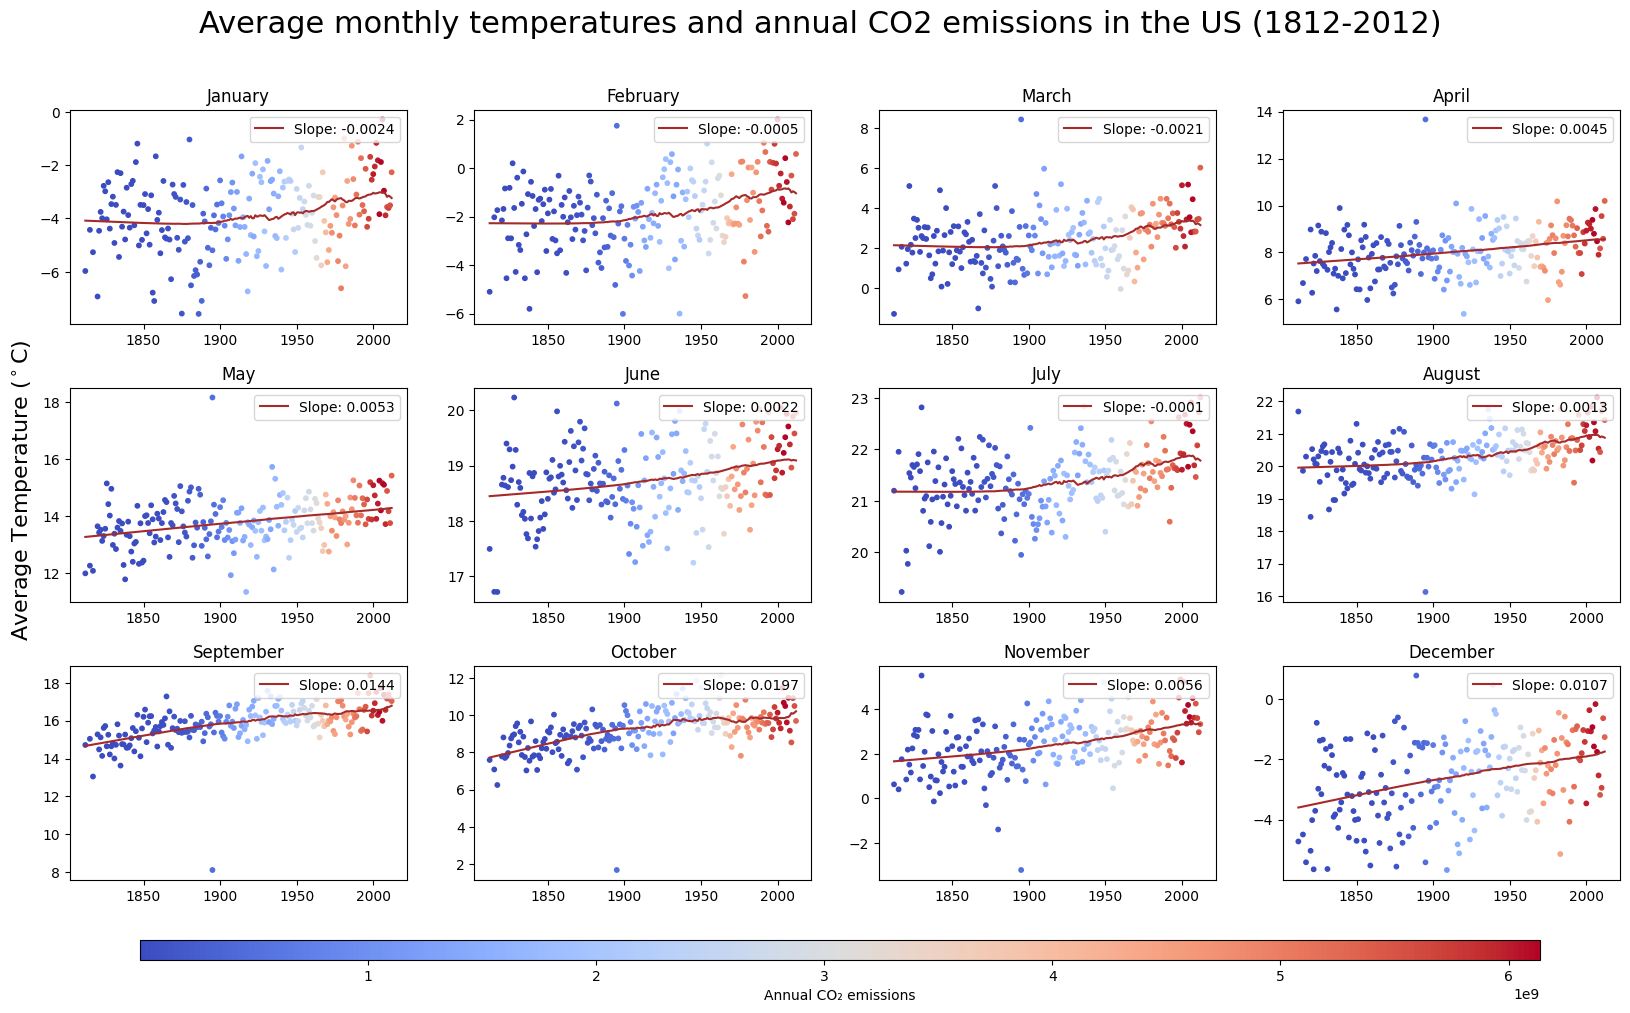

In [185]:
nrows = 3
ncols = 4
plt.rcParams['figure.figsize'] = [20, 10]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.text(0.095, 0.5, 'Average Temperature ($^\circ$C)', va='center',
         rotation='vertical',fontsize=16)

for index, month in enumerate(month_names):
#     # Calculate Spearman's rank correlation coefficient
#     spearman_corr, _ = spearmanr(X[:, 0], Y_pred[:, index])
    ax = axes[index // ncols, index % ncols]
    sc = ax.scatter(X[:,0], Y[:,index], c=X[:, 1], cmap='coolwarm', s=10)
    ax.set_title(month)
    ax.plot(X[:,0], Y_pred[:,index], color='brown', label=f'Slope: {coefficients[index][0]:.4f}')
    ax.legend(loc="upper right")
    
#plt.set_ylabel('Average Temperatures (°C)')
# Set the colorbar for CO2 emissions
#cbar = fig.colorbar(ax.collections[0], cax=ax_co2)
cbar_ax = fig.add_axes([0.16, 0.03, 0.7, 0.02])
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Annual CO₂ emissions')
fig.suptitle('Average monthly temperatures and annual CO2 emissions in the US (1812-2012)', fontsize=22)
plt.show()

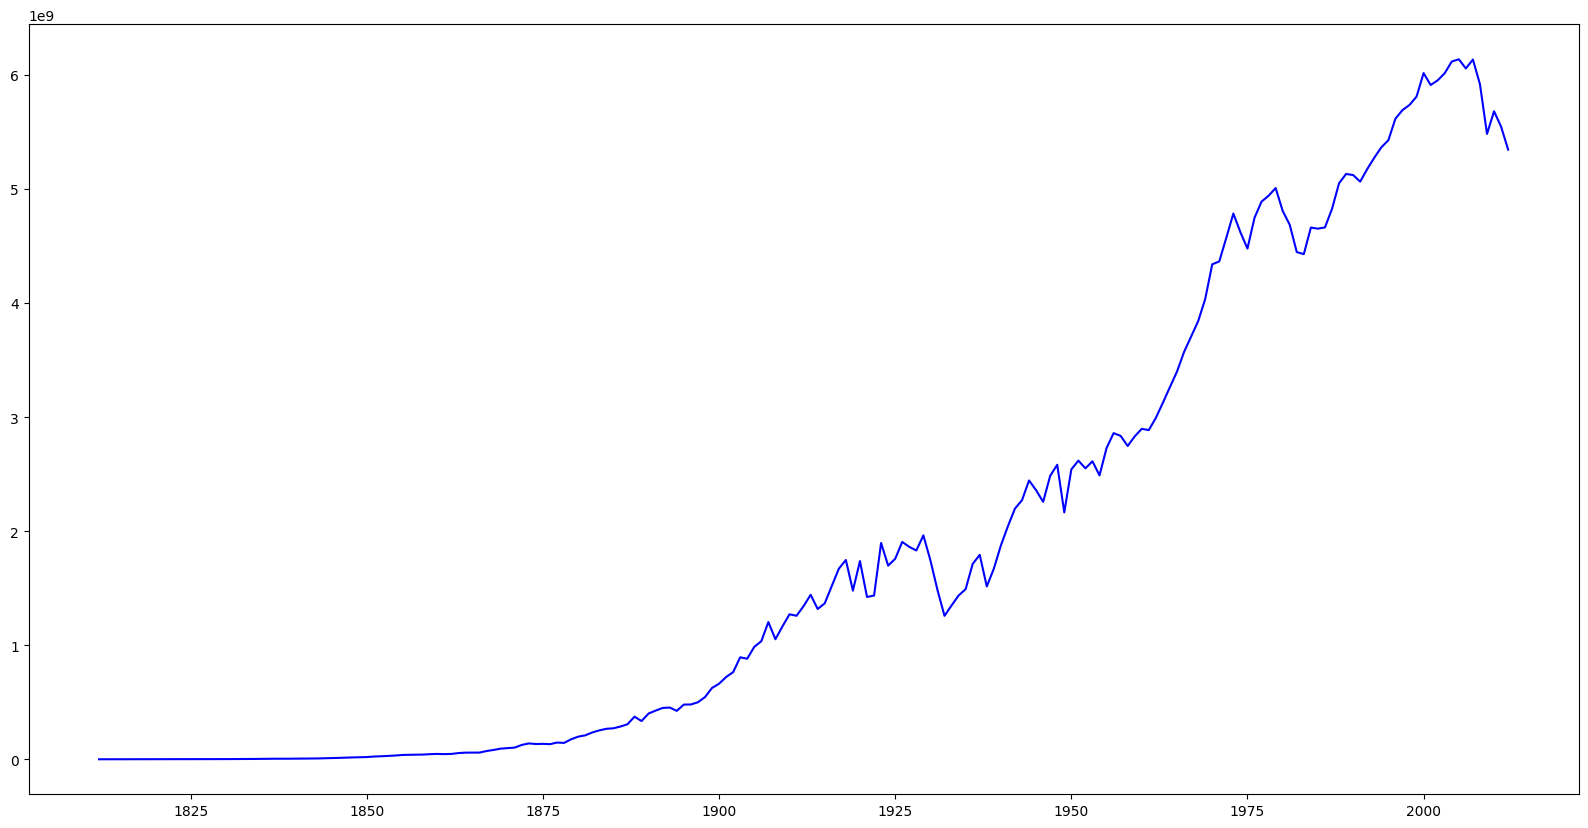

In [51]:
# Add a subplot for CO2 emissions
fig_co2, ax_co2 = plt.subplots()

# Plot CO2 emissions over time
ax_co2.plot(X[:, 0], X[:, 1], color='blue', label='CO2 Emissions')

ax_co2.set_xlabel('Year')
ax_co2.set_ylabel('Emission levels (in billions)')
plt.show()

In [129]:
import numpy as np

# Extract the average temperature and CO2 emissions columns
temperatures = temp_co2_US[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']].toPandas().values
co2_emissions = temp_co2_US[['Annual CO₂ emissions']].toPandas().values

In [130]:
print("Shape of temperatures array:", temperatures.shape)
print("Shape of co2_emissions array:", co2_emissions.shape)

Shape of temperatures array: (196, 12)
Shape of co2_emissions array: (196, 1)


In [155]:
print('Correlation coefficient between C02 emissions and average temperatures for month of\n')
for index, month in enumerate(month_names):
    corr = np.corrcoef(temperatures[:, index], co2_emissions.flatten())[0, 1]
    print(f'{month}: {corr}')

Correlation coefficient between C02 emissions and average temperatures for month of

January: 0.27178216594232435
February: 0.32509897474857535
March: 0.3179925913105362
April: 0.28577875259012986
May: 0.3166847894757217
June: 0.2945680511472273
July: 0.3819509456970544
August: 0.46743179407100643
September: 0.4821375509423594
October: 0.4447967509490451
November: 0.4190641920835464
December: 0.34082792301027587
